# SPAM detection with NLP processing

The project is to build a model able to dectect wether an SMS is an spam or not. To do so we will first treat the SMS with **NLP mehtod**. 

Then we will try to apply an **classification model** on the treated SMS



### package import

In [74]:
import pandas as pd
import spacy
import re
from unidecode import unidecode
import string
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , classification_report
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
nltk.download('stopwords')
from nltk.corpus import stopwords

#change the working directory if necessary
df_eng=pd.read_csv(r'C:\Users\UTILISATEUR\Desktop\Spam\Spam_dataset.csv',sep=';')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\UTILISATEUR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **EDA** (Exploratory Data Analysis)

In [75]:
df_eng['Nature'].value_counts()

ham     4825
spam     747
Name: Nature, dtype: int64

Ham is over represented we risk that the model will overfit on the ham. We will ve carefull before trying to build a predictive model

### Cleaning the sms

In [76]:
#python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [77]:
#Remove upper case
df_eng.SMS=df_eng.SMS.str.lower()

#remove accent
df_eng.SMS=df_eng.SMS.apply(lambda text: unidecode(text))


# Replace email address with 'emailaddress'
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress',x))

# Replace urls with 'webaddress'
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'http?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', 'webaddress',x))
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'^https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', 'webaddress',x))

# Replace money symbol with 'money-symbol'
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'£|\$', 'money-symbol',x))

#replace numbers
df_eng.SMS=df_eng.SMS.apply(lambda x: re.sub(r'\d{10,15}','phonenumber',x))
df_eng.SMS=df_eng.SMS.apply(lambda x: re.sub(r'\d+','number',x))



#retirer la ponctuation
df_eng.SMS=df_eng.SMS.apply(lambda text: text.translate(str.maketrans(string.punctuation ,' '*len(string.punctuation ))
                                                             ).replace(' '*4,' ').replace(' '*3,' ').replace(' '*2,' ').strip())

### Lemmatize the sms

In [78]:
#Function to lemmatize the text and take out some ponctuation and the names of peoples
def lemmatize(text):
    lemmatized_array=[]
    doc=nlp(u'{}'.format(text))
    for token in doc:
        if token.lemma_ not in ("'",",","[","]") and (not token.ent_type_ == "PER"):
            lemmatized_array.append(token.lemma_)
    return lemmatized_array

In [79]:
df_nlp_eng=df_eng.copy()

In [80]:
df_nlp_eng.SMS=df_nlp_eng.SMS.apply(lambda x: lemmatize(x))

### Stopwords treatment

In [ ]:
stopWords = set(stopwords.words('english'))
stopWords.update(('nt','pl','c'))
def remove_sw(text):
    return[w for w in text if w not in stopWords]

In [ ]:
df_nlp_eng.SMS=df_nlp_eng.SMS.apply(lambda text: remove_sw(text))

### Word cloud

In [ ]:
df_cloud=df_nlp_eng.copy()

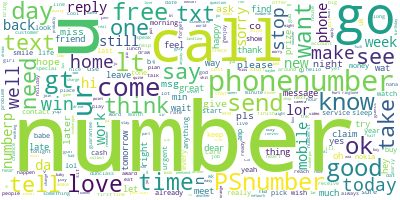

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
df_cloud.SMS=df_cloud.SMS.apply(lambda x: ' '.join(x))
long_string = ','.join(list(df_cloud.SMS.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

##### Word cloud of spams and non spam

In [ ]:
df_cloud_ham=df_nlp_eng[df_nlp_eng['Nature']=='ham']
df_cloud_spam=df_nlp_eng[df_nlp_eng['Nature']=='spam']

c:\Users\UTILISATEUR\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


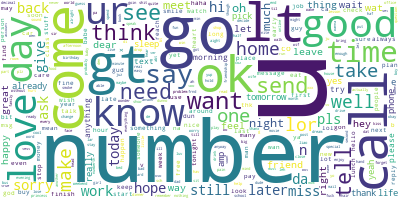

In [ ]:
df_cloud_ham.SMS=df_cloud_ham.SMS.apply(lambda x: ' '.join(x))
long_string = ','.join(list(df_cloud_ham.SMS.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

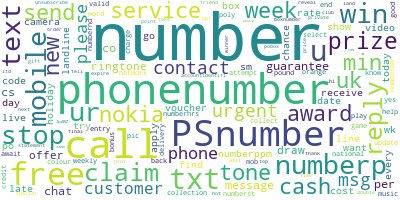

In [ ]:
df_cloud_spam.SMS=df_cloud_spam.SMS.apply(lambda x: ' '.join(x))
long_string = ','.join(list(df_cloud_spam.SMS.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Predictive model

#### Downsampling the data

In [ ]:
# check percentage of data - states how much data needs to be balanced
print(str(round(747/4825,2))+'%')

0.15%


In [ ]:
#clear empty fields
df_nlp_eng=df_nlp_eng[df_nlp_eng['SMS'].map(len)>0]

#we separe the two type of data
df_ham=df_nlp_eng[df_nlp_eng['Nature']=='ham']
df_spam=df_nlp_eng[df_nlp_eng['Nature']=='spam']

In [ ]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [ ]:
# get the balanced dataset
df_model= pd.concat([df_spam , df_ham_downsampled])

In [ ]:
#Change the categorical variable to numerical one
df_model['is_spam']=df_model['Nature'].apply(lambda x: 1 if x=='spam'else 0)

#### Compute the TF-IDF score

In [ ]:
#Join the list of word to apply the tf_idf
df_model.SMS=df_model.SMS.apply(lambda x: ' '.join(x))
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform(df_model.SMS)

In [ ]:
#Convert the result to a dataframe and reset the index to the right one
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_df.set_index(df_model.index,inplace=True)

In [ ]:
#Concatenate the score of tf-idf and the initial dataframe
df_model=pd.concat([df_model , tfidf_df],axis=1)

#### Random Forest Classifier Reg

In [ ]:
X_model=df_model[df_model.columns.difference(['Nature', 'SMS','is_spam'])]
y=df_model[['is_spam']]
X_train, X_test, y_train, y_test = train_test_split( X_model, y, test_size=0.33, random_state=42)

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

<ipython-input-69-8a5c39954b34>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


In [ ]:
df_=(df_model.merge(X_test, left_index=True,right_index=True ,how='inner')).merge(pd.DataFrame({'pred':list(y_pred),'index': X_test.index}).set_index('index'),left_index=True,right_on='index')


In [ ]:
for i in df_[df_['is_spam']!=df_['pred']].index:
    print(df_.loc[i,'SMS'])

sm ac sptv new jersey devil detroit red wing play ice hockey correct incorrect end reply end sptv
unique enough find numberth august www areyouunique co uk
sm ac blind date numberu roddsnumber number aberdeen united kingdom check http img sm ac w icmbnumbercktznumberrnumber number blind date send hide
important customer service announcement premier
reminder download content already pay goto http doit mymoby tv collect content
claire havin borin time alone u wanna cum numbernite chat phonenumber hope number u luv claire xx callspsnumber minmoremobsemspoboxnumberponumberwa
buy one ringtone get text cost number pound offer tone etc
would like see xxx pic hot nearly ban uk
sexy single wait text age follow gender wither f e g numberf gay man text age follow g e g numberg
hi ya babe x u numbergoten bout I scammer get smart though regular vodafone respond get prem rate msg subscription nos use also beware
guess I first time I create web page www asjesus com read I write I wait opinion I want 

In [ ]:
list(df_[df_['is_spam']!=df_['pred']].index)

[]

#### Visualisation error

In [ ]:
cm = confusion_matrix(y_test,y_pred)

Text(33.0, 0.5, 'Actual')

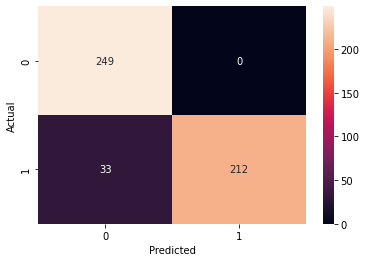

In [ ]:
# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#### Model on the whole dataset

In [ ]:
df_test=df_nlp_eng.copy()

In [ ]:
#Join the list of word to apply the tf_idf
df_test.SMS=df_test.SMS.apply(lambda x: ' '.join(x))
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform(df_test.SMS)

In [ ]:
#Convert the result to a dataframe and reset the index to the right one
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_df.set_index(df_test.index,inplace=True)

In [ ]:
#Concatenate the score of tf-idf and the initial dataframe
df_test=pd.concat([df_test , tfidf_df],axis=1)

Text(33.0, 0.5, 'Actual')

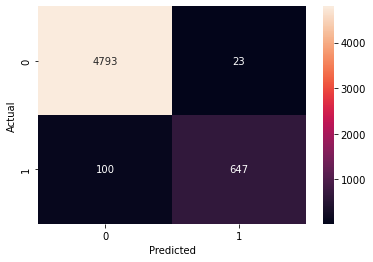

In [ ]:
df_test['is_spam']=df_test['Nature'].apply(lambda x: 1 if x=='spam'else 0)


X=df_test[df_test.columns.difference(['Nature', 'SMS','is_spam'])]
X=X[X_model.columns]
y=df_test[['is_spam']]
y_pred=clf.predict(X)
cm = confusion_matrix(y,y_pred)

# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### To develop:
* n-gram
* model to use
* TF-IDF

```

# Replace email address with 'emailaddress'
df['message'] = df['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

# Replace urls with 'webaddress'
df['message'] = df['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Replace money symbol with 'money-symbol'
df['message'] = df['message'].str.replace(r'£|\$', 'money-symbol'
Can help:

```


https://dimensionless.in/spam-detection-with-natural-language-processing-part-2/

https://www.analyticsvidhya.com/blog/2021/09/performing-email-spam-detection-using-bert-in-python/
